# Learning a Communication Channel

When using non-adaptive FPGA ensembles (i.e., the `learning_rate` is set to 0), the ensemble's decoded output function can be defined by providing the `FpgaPesEnsembleNetwork` constructor with the `function` keyword (e.g., `function=lambda t: sin(t)`). Adaptive (learning) FPGA ensembles augment this feature by allowing the use of error-driving learning to compute these function in an "online" manner.

## Step 1: Set up the Python Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import nengo
from nengo.processes import WhiteSignal

import nengo_fpga
from nengo_fpga.networks import FpgaPesEnsembleNetwork

## Step 2: Choose an FPGA Device

Define the FPGA device on which the remote FpgaPesEnsembleNetwork will run. This name corresponds with the name in your `fpga_config` file. Recall that in the `fpga_config` file, device names are identified by the square brackets (e.g., **[de1]** or **[pynq]**). The names defined in your configuration file might differ from the example below. Here, the device **de1** is being used.

In [2]:
board = 'de1'  # Change this to your desired device name

## Step 3: Create the Remote FPGA Neural Ensemble

Create a remote FPGA neural ensemble (`FpgaPesEnsembleNetwork`) using the board defined above, 100 neurons, 1 dimension, and a learning rate of `5e-5`.

In [3]:
# Create a nengo network object to which we can add
# ensembles, connections, etc.
model = nengo.Network(label="Learned Communication Channel")

with model:
    # Remote FPGA neural ensemble
    fpga_ens = FpgaPesEnsembleNetwork(
        board,  # The board to use (from above)
        n_neurons=100,  # The number of neurons to use in the ensemble
        # Number of dimensions for the ensemble to represent
        dimensions=1,
        learning_rate=5e-5,  # Desired learning rate
        # Provide a random function as initialization
        function=lambda x: np.random.random(x.shape)
    )

    # Uncomment the following line to use spiking neuron
    # fpga_ens.ensemble.neuron_type = nengo.SpikingRectifiedLinear()

## Step 4: Provide Input to the Ensemble

Create an input node that generates a white-noise signal. This is what will be used to demonstrate the efficacy of the learning.

In [4]:
with model:
    # White-noise reference signal
    input_node = nengo.Node(WhiteSignal(60, high=5))

## Step 5: Connect the Input to the FPGA Ensemble

The FPGA ensemble contains `input` and `output` attributes to allow connections to be made to and from the ensemble.

In [5]:
with model:
    # Connect the input to the FPGA ensemble
    nengo.Connection(input_node, fpga_ens.input)

## Step 6: Add Probes to Collect Data

In [6]:
with model:
    # The original input
    input_p = nengo.Probe(input_node, synapse=0.01)

    # The output from the FPGA ensemble
    # (filtered with a 10ms post-synaptic filter)
    output_p = nengo.Probe(fpga_ens.output, synapse=0.01)

## Step 7: Test the Model Without Learning

In Step 5, only the connection between the input signal and the FPGA ensemble was made. Without a learning signal connected to the FPGA ensemble, the ensemble will behave as if the learning was disabled. To demonstrate this, run the model as it is, and plot the output. From the output graph, it should be apparent that the FPGA ensemble does not compute a useful value.

In [7]:
with nengo_fpga.Simulator(model) as sim:
    sim.run(10)

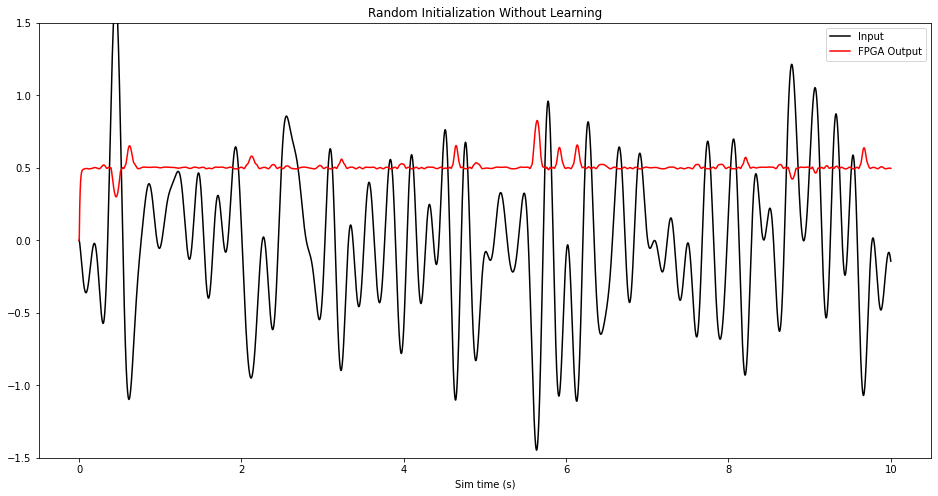

In [8]:
# Plot figure
plt.figure(figsize=(16, 8))
plt.plot(sim.trange(), sim.data[input_p], c='k', label='Input')
plt.plot(sim.trange(), sim.data[output_p], c='r', label='FPGA Output')
plt.ylim(-1.5, 1.5)
plt.legend(loc='upper right')
plt.xlabel("Sim time (s)")
plt.title("Random Initialization Without Learning");

## Step 8: Add Learning

The adaptive component of the FPGA ensemble works by implementing the `nengo.PES` learning rule. The `nengo.PES` learning rule in turn requires an error signal to function correctly. In this example, the error signal will be computed such that the FPGA ensemble learns to behave like a communication channel.

Mathematically, the error signal $e$ can be defined as:

$$e = \hat{x} - x,$$

where $x$ is the reference signal (target value), and $\hat{x}$ is the output of the FPGA ensemble (actual value).

To represent (and compute) the error signal in the Nengo model, an additional (non-FPGA) neural ensemble is required. Connections are made to this ensemble with the appropriate transformations to perform the subtraction function.

Finally, the output of the error ensemble is connected to the `error` attribute of the `fpga_ens`, and this provides the FPGA ensemble with the appropriate error signal.

In [9]:
with model:
    # Create a neural ensemble to calculate the error signal
    error = nengo.Ensemble(60, dimensions=1)

    # Compute the error (error = actual - target) using transforms
    # on the connections to the error ensemble
    nengo.Connection(fpga_ens.output, error)
    nengo.Connection(input_node, error, transform=-1)

    # Project error to the adaptive neural ensemble on the FPGA
    nengo.Connection(error, fpga_ens.error)

    # Add a probe of the error signal
    error_p = nengo.Probe(error, synapse=0.03)

The effect the adaptation has on the behaviour of the FPGA ensemble can now be demonstrated by running the model, and plotting the results.

In [10]:
with nengo_fpga.Simulator(model) as sim:
    sim.run(10)

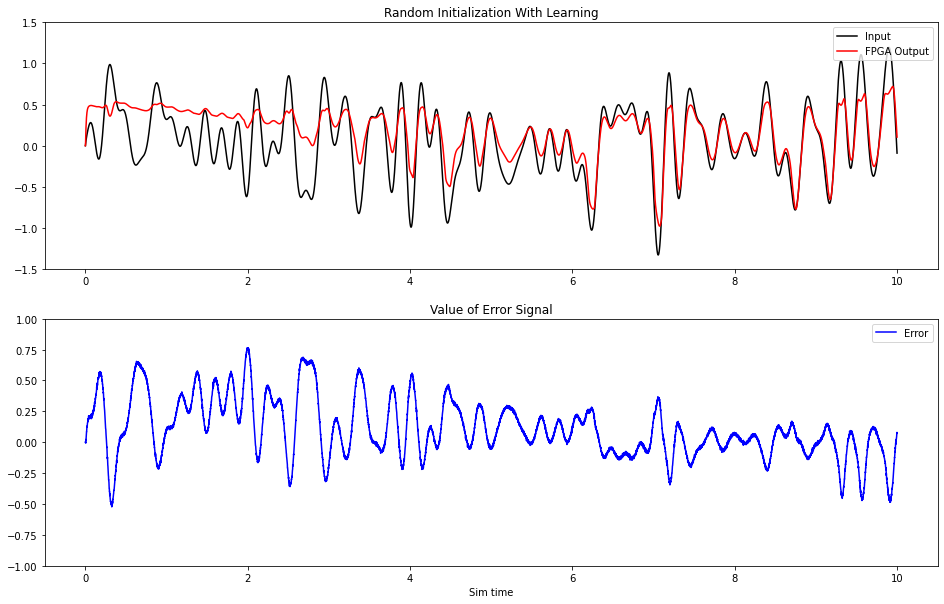

In [11]:
plt.figure(figsize=(16, 10))
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[input_p], c='k', label='Input')
plt.plot(sim.trange(), sim.data[output_p], c='r', label='FPGA Output')
plt.ylim(-1.5, 1.5)
plt.legend(loc='upper right')
plt.title("Random Initialization With Learning")

plt.subplot(2, 1, 2)
plt.plot(sim.trange(), sim.data[error_p], c='b', label="Error")
plt.ylim(-1, 1)
plt.xlabel("Sim time")
plt.legend(loc='upper right')
plt.title("Value of Error Signal");

The plot above show that with the learning enabled, the output of the FPGA ensemble (red) slowly adapts to match the reference white noise signal (black). Additionally, it is observed that as the simulation progresses, the value of the error signal (blue) gradually decreases.

## Does it generalize?

The adaptive FPGA ensemble will continually adapt it's decoded output as long as an error signal is provided (i.e., it will always work to minimize the value of the error signal). However, an important consideration is figure out if the FPGA ensemble has learned general communication channel function. That is to say, has the FPGA ensemble learned the communication channel function across a range of inputs, or has it only adapted to the specific sequence of input it has been shown.

If the FPGA ensemble has computed a generalized function, it should still function as a communication channel when the learning is disabled. To disable the learning, the activity of the `error` ensemble can be inhibited, thus providing no error signal. In the code below, an inhibitory connection is made to the `error` ensemble that inhibits it after the simulation has run for 10 seconds.

In [12]:
def inhibit(t):
    return 5.0 if t > 10.0 else 0.0


with model:
    inhib = nengo.Node(inhibit)
    nengo.Connection(inhib, error.neurons,
                     transform=[[-1]] * error.n_neurons)

With the inhibitory connection made, the model can be run (for 16 seconds this time -- the first 10 seconds of which the FPGA ensemble is learning, followed by 6 seconds where the `error` ensemble is inhibited).

In [13]:
with nengo_fpga.Simulator(model) as sim:
    sim.run(16)

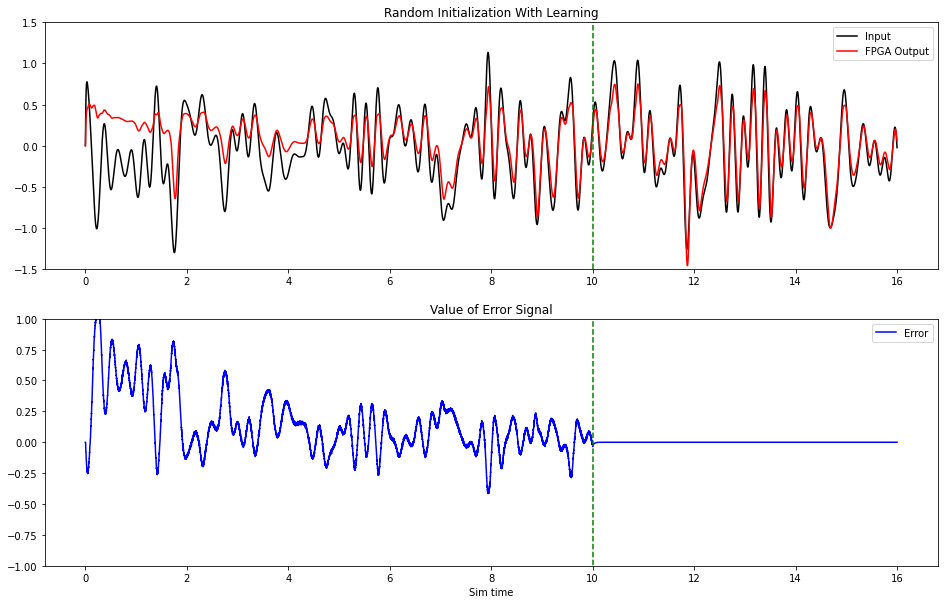

In [14]:
plt.figure(figsize=(16, 10))
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[input_p], c='k', label='Input')
plt.plot(sim.trange(), sim.data[output_p], c='r', label='FPGA Output')
plt.ylim(-1.5, 1.5)
plt.legend(loc='upper right')
plt.plot([10, 10], [-1.5, 1.5], 'g--')
plt.title("Random Initialization With Learning")

plt.subplot(2, 1, 2)
plt.plot(sim.trange(), sim.data[error_p], c='b', label="Error")
plt.ylim(-1, 1)
plt.xlabel("Sim time")
plt.legend(loc='upper right')
plt.plot([10, 10], [-1.5, 1.5], 'g--')
plt.title("Value of Error Signal");

From the plots above, the following observations can be made:

1. The output of the error ensemble (blue) goes to zero when it is inhibited.
2. The FPGA ensemble continues to behave like a communication channel even after the learning is disabled (the green dotted line). This demonstrates that the FPGA ensemble has learned behave like a general communication channel.

## How Does This Work?

Since many of the internal dynamics of the FPGA ensemble are not probable (for sake of performance), it is difficult to explore the details of the implementation here. Take a look at the [learn_communication_channel](https://www.nengo.ai/nengo/examples/learning/learn-communication-channel.html#How-does-this-work?)
example built with standard Nengo for an explanation of the learning rule and how the connection weights changes as the learning rule is applied.